In [2]:
# Setup environment
%run 0-Environment_Setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Normalization, Flatten, Dropout 
from tensorflow.keras.layers import Concatenate, GaussianNoise, Lambda
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, RNN, GRU
from sklearn import preprocessing

2024-10-07 19:38:15.878355: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 19:38:15.880629: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 19:38:15.884019: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-07 19:38:15.894205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 19:38:15.913931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [38]:
# Set session variables
from sagemaker.tensorflow import TensorFlow

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_session.region_name
bucket = sess.default_bucket()

train_prefix = "store-sales-forecasting/train"
test_prefix = "store-sales-forecasting/test"
val_prefix = "store-sales-forecasting/val"

In [90]:
# Create a temporary directory for saving data
import os
local_path = f"{os.getcwd()}/tmp"
if not os.path.exists(local_path):
    os.makedirs(local_path)

In [81]:
# Pull the data from the feature store sorted by date and then store number
sales_features_store_df = get_store_dataset_from_offline_feature_group_date_sort(store_sales_feature_group)
sales_features_store_df.head()

INFO:sagemaker:Query 01abeee4-b353-4fdf-9180-8a6a882aa000 is being executed.


Running 
    SELECT *
    FROM
        "store_sales_feature_group_offline_1728164033"
    ORDER BY
        date ASC, store_nbr ASC
    


INFO:sagemaker:Query 01abeee4-b353-4fdf-9180-8a6a882aa000 successfully executed.


,date,store_nbr,sales,oil,onpromotion,is_holiday,city,state,cluster,year,...,month_sin,day_cos,day_sin,dow_cos,dow_sin,sales_record_id,event_time,write_time,api_invocation_time,is_deleted
0,2013-01-01,1,0.0,93.14,0,1,18,12,13,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:1,1.728164e+09,2024-10-05 21:39:49.912,2024-10-05 21:34:48.000,False
1,2013-01-01,2,0.0,93.14,0,1,18,12,13,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:2,1.728164e+09,2024-10-05 21:39:50.076,2024-10-05 21:34:48.000,False
2,2013-01-01,3,0.0,93.14,0,1,18,12,8,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:3,1.728164e+09,2024-10-05 21:39:49.967,2024-10-05 21:34:48.000,False
3,2013-01-01,4,0.0,93.14,0,1,18,12,9,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:4,1.728164e+09,2024-10-05 21:39:50.013,2024-10-05 21:34:48.000,False
4,2013-01-01,5,0.0,93.14,0,1,21,14,4,2013,...,0.5,0.97953,0.201299,0.62349,0.781831,2013-01-01:5,1.728164e+09,2024-10-05 21:39:50.068,2024-10-05 21:34:48.000,False


In [82]:
# Drop miscellaneous info
sales_features_store_df.drop(columns=["sales_record_id", "event_time", "write_time", "api_invocation_time", "is_deleted"], inplace=True)

In [6]:
sales_features_store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90936 entries, 0 to 90935
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                90936 non-null  object 
 1   store_nbr           90936 non-null  int64  
 2   sales               90936 non-null  float64
 3   oil                 90936 non-null  float64
 4   onpromotion         90936 non-null  int64  
 5   is_holiday          90936 non-null  int64  
 6   city                90936 non-null  int64  
 7   state               90936 non-null  int64  
 8   cluster             90936 non-null  int64  
 9   year                90936 non-null  int64  
 10  month               90936 non-null  int64  
 11  day                 90936 non-null  int64  
 12  dow                 90936 non-null  int64  
 13  city-state          90936 non-null  object 
 14  city-state-cluster  90936 non-null  object 
 15  hash_0              90936 non-null  float64
 16  hash

In [83]:
# Perform feature selection
def get_store_features(row):
    return [
      row["sales"], 
      row["oil"], 
      row["onpromotion"],
      # row["is_holiday"], 
      # row["hash_0"], 
      # row["hash_1"], 
      # row["hash_2"], 
      # row["hash_3"], 
      # row["hash_4"], 
      # row["hash_5"], 
      # row["hash_6"], 
      # row["hash_7"], 
      # row["hash_8"], 
      # row["hash_9"], 
      row["month_cos"],
      row["month_sin"],
      row["day_cos"],
      row["day_sin"],
      # row["dow_cos"],
      # row["dow_sin"]
]

sales_features_store_df.head().apply(get_store_features, axis=1)

0    [0.0, 93.14, 0, 0.8660254037844387, 0.49999999...
1    [0.0, 93.14, 0, 0.8660254037844387, 0.49999999...
2    [0.0, 93.14, 0, 0.8660254037844387, 0.49999999...
3    [0.0, 93.14, 0, 0.8660254037844387, 0.49999999...
4    [0.0, 93.14, 0, 0.8660254037844387, 0.49999999...
dtype: object

In [84]:
# Apply to the whole dataframe
sales_features_store_df["features"] = sales_features_store_df.apply(get_store_features, axis=1)

In [85]:
# Drop everything except the store number, date, and selected features
drop_columns = [col for col in sales_features_store_df.columns if col not in ["date", "store_nbr", "features"]]
sales_features_store_df.drop(columns=drop_columns, inplace=True)
sales_features_store_df.head()

,date,store_nbr,features
0,2013-01-01,1,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999..."
1,2013-01-01,2,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999..."
2,2013-01-01,3,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999..."
3,2013-01-01,4,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999..."
4,2013-01-01,5,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999..."


In [86]:
# Pivot the data to be in the format (store number, date, features)
sales_data_pivoted = sales_features_store_df.pivot(index="store_nbr", columns="date", values="features")
sales_data_pivoted.head()

date,2013-01-01,2013-01-02,2013-01-03,2013-01-04,2013-01-05,2013-01-06,2013-01-07,2013-01-08,2013-01-09,2013-01-10,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15
store_nbr,,,,,,,,,,,,,,,,,,,,,
1,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999...","[7417.15, 93.14, 0, 0.8660254037844387, 0.4999...","[5873.24, 92.97, 0, 0.8660254037844387, 0.4999...","[5919.88, 93.12, 0, 0.8660254037844387, 0.4999...","[6318.79, 93.12, 0, 0.8660254037844387, 0.4999...","[2199.09, 93.12, 0, 0.8660254037844387, 0.4999...","[6150.92, 93.2, 0, 0.8660254037844387, 0.49999...","[5597.18, 93.21, 0, 0.8660254037844387, 0.4999...","[6808.58, 93.08, 0, 0.8660254037844387, 0.4999...","[4757.71, 93.81, 0, 0.8660254037844387, 0.4999...",...,"[4409.25, 49.57, 29, -0.5000000000000004, -0.8...","[10538.14, 49.37, 44, -0.5000000000000004, -0....","[11070.76, 49.07, 35, -0.5000000000000004, -0....","[12583.65, 49.59, 212, -0.5000000000000004, -0...","[10834.58, 48.54, 31, -0.5000000000000004, -0....","[5403.74, 48.81, 38, -0.5000000000000004, -0.8...","[7543.62, 48.81, 28, -0.5000000000000004, -0.8...","[3902.78, 48.81, 19, -0.5000000000000004, -0.8...","[10433.31, 47.59, 30, -0.5000000000000004, -0....","[9823.55, 47.57, 29, -0.5000000000000004, -0.8..."
2,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999...","[10266.72, 93.14, 0, 0.8660254037844387, 0.499...","[7612.54, 92.97, 0, 0.8660254037844387, 0.4999...","[7526.38, 93.12, 0, 0.8660254037844387, 0.4999...","[9539.57, 93.12, 0, 0.8660254037844387, 0.4999...","[10322.39, 93.12, 0, 0.8660254037844387, 0.499...","[6675.97, 93.2, 0, 0.8660254037844387, 0.49999...","[6109.57, 93.21, 0, 0.8660254037844387, 0.4999...","[6740.52, 93.08, 0, 0.8660254037844387, 0.4999...","[5565.04, 93.81, 0, 0.8660254037844387, 0.4999...",...,"[16987.57, 49.57, 43, -0.5000000000000004, -0....","[12382.45, 49.37, 39, -0.5000000000000004, -0....","[11304.55, 49.07, 38, -0.5000000000000004, -0....","[12615.75, 49.59, 213, -0.5000000000000004, -0...","[11317.83, 48.54, 26, -0.5000000000000004, -0....","[13081.77, 48.81, 57, -0.5000000000000004, -0....","[12382.42, 48.81, 33, -0.5000000000000004, -0....","[13766.82, 48.81, 32, -0.5000000000000004, -0....","[12211.46, 47.59, 36, -0.5000000000000004, -0....","[11196.26, 47.57, 33, -0.5000000000000004, -0...."
3,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999...","[24060.35, 93.14, 0, 0.8660254037844387, 0.499...","[18570.75, 92.97, 0, 0.8660254037844387, 0.499...","[17392.1, 93.12, 0, 0.8660254037844387, 0.4999...","[22700.87, 93.12, 0, 0.8660254037844387, 0.499...","[25343.62, 93.12, 0, 0.8660254037844387, 0.499...","[17036.25, 93.2, 0, 0.8660254037844387, 0.4999...","[14220.42, 93.21, 0, 0.8660254037844387, 0.499...","[14735.15, 93.08, 0, 0.8660254037844387, 0.499...","[12222.91, 93.81, 0, 0.8660254037844387, 0.499...",...,"[42005.37, 49.57, 43, -0.5000000000000004, -0....","[32074.15, 49.37, 41, -0.5000000000000004, -0....","[28450.84, 49.07, 40, -0.5000000000000004, -0....","[32962.39, 49.59, 222, -0.5000000000000004, -0...","[26035.93, 48.54, 30, -0.5000000000000004, -0....","[32885.76, 48.81, 67, -0.5000000000000004, -0....","[31903.48, 48.81, 34, -0.5000000000000004, -0....","[34845.12, 48.81, 36, -0.5000000000000004, -0....","[32843.7, 47.59, 34, -0.5000000000000004, -0.8...","[30185.6, 47.57, 33, -0.5000000000000004, -0.8..."
4,"[0.0, 93.14, 0, 0.8660254037844387, 0.49999999...","[10200.08, 93.14, 0, 0.8660254037844387, 0.499...","[7400.25, 92.97, 0, 0.8660254037844387, 0.4999...","[6902.05, 93.12, 0, 0.8660254037844387, 0.4999...","[9948.38, 93.12, 0, 0.8660254037844387, 0.4999...","[11679.69, 93.12, 0, 0.8660254037844387, 0.499...","[6748.2, 93.2, 0, 0.8660254037844387, 0.499999...","[6017.61, 93.21, 0, 0.8660254037844387, 0.4999...","[5867.88, 93.08, 0, 0.8660254037844387, 0.4999...","[4674.25, 93.81, 0, 0.8660254037844387, 0.4999...",...,"[16801.05, 49.57, 32, -0.5000000000000004, -0....","[10214.14, 49.37, 29, -

In [87]:
# Convert the data to an array
stacked_sales_data = np.array(sales_data_pivoted.values.tolist())
stacked_sales_data.shape

(54, 1684, 7)

In [88]:
# Split the data into test/train/val sets with a 60/20/20 split
n = stacked_sales_data.shape[1]
train_data = stacked_sales_data[:, :int(n*0.6), :]
test_data = stacked_sales_data[:, int(n*0.6):int(n*0.8), :]
val_data = stacked_sales_data[:, int(n*0.8):, :]
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

Train data shape: (54, 1010, 7)
Test data shape: (54, 337, 7)
Validation data shape: (54, 337, 7)


In [91]:
# Get the mean and standard deviation for normalization
scaler = preprocessing.StandardScaler()
train_data_2d = train_data.reshape(-1, train_data.shape[2])
scaler.fit(train_data_2d[:, :3])

global_mean = scaler.mean_
global_stddev = scaler.scale_

print(global_mean, global_stddev)

# Save mean and standard deviation arrays to S3
np.save(f"{local_path}/global_mean.npy", global_mean)
np.save(f"{local_path}/global_stddev.npy", global_stddev)

sagemaker_session.upload_data(f"{local_path}/global_mean.npy", bucket=bucket, key_prefix=train_prefix)
sagemaker_session.upload_data(f"{local_path}/global_stddev.npy", bucket=bucket, key_prefix=train_prefix)

[9754.29461184   83.15427319   11.49229923] [8771.22271946   22.17583982   29.16430315]


's3://sagemaker-us-east-1-757929513207/store-sales-forecasting/train/global_stddev.npy'

In [92]:
# Define a function that breaks the data into time series windows of a specified size
# input_seq_length: The length of the input window
# target_seq_length: The length of the target (prediction) window
# stride: How much the windows overlap. A stride of 1 means each set of input/targets is shifted 1 day forward from the last input/targets
def generate_windows(data, input_seq_length, target_seq_length, stride):
    windows = []
    targets = []
    num_days = data.shape[1]
    
    for i in range(0, num_days, stride):
        if (i+input_seq_length+target_seq_length) <= num_days:
            input_window_end = i + input_seq_length
            target_window_end = input_window_end + target_seq_length
            
            input_window = data[:, i:input_window_end, :]
            target_window = data[:, input_window_end:target_window_end, 0]
            
            windows.append(input_window)
            targets.append(target_window)
            
    return np.array(windows), np.array(targets)

In [93]:
# Generate windows for train/test/val sets
input_seq_length = 14
target_seq_length = 7
stride = 1

train_inputs, train_targets = generate_windows(train_data, input_seq_length, target_seq_length, stride)
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Train targets shape: {train_targets.shape}")

continuous_train_inputs = train_inputs[:, :, :, :3]
categorical_train_inputs = train_inputs[:, :, :, 3:]
print(f"Continuous train inputs shape: {continuous_train_inputs.shape}")
print(f"Categorical train inputs shape: {categorical_train_inputs.shape}\n")

test_inputs, test_targets = generate_windows(test_data, input_seq_length, target_seq_length, stride)
print(f"Test inputs shape: {test_inputs.shape}")
print(f"Test targets shape: {test_targets.shape}")

continuous_test_inputs = test_inputs[:, :, :, :3]
categorical_test_inputs = test_inputs[:, :, :, 3:]
print(f"Continuous test inputs shape: {continuous_test_inputs.shape}")
print(f"Categorical test inputs shape: {categorical_test_inputs.shape}\n")

val_inputs, val_targets = generate_windows(val_data, input_seq_length, target_seq_length, stride)
print(f"Validation inputs shape: {val_inputs.shape}")
print(f"Validation inputs shape: {val_targets.shape}")

continuous_val_inputs = val_inputs[:, :, :, :3]
categorical_val_inputs = val_inputs[:, :, :, 3:]
print(f"Continuous validation inputs shape: {continuous_val_inputs.shape}")
print(f"Categorical validation inputs shape: {categorical_val_inputs.shape}")

Train inputs shape: (990, 54, 14, 7)
Train targets shape: (990, 54, 7)
Continuous train inputs shape: (990, 54, 14, 3)
Categorical train inputs shape: (990, 54, 14, 4)

Test inputs shape: (317, 54, 14, 7)
Test targets shape: (317, 54, 7)
Continuous test inputs shape: (317, 54, 14, 3)
Categorical test inputs shape: (317, 54, 14, 4)

Validation inputs shape: (317, 54, 14, 7)
Validation inputs shape: (317, 54, 7)
Continuous validation inputs shape: (317, 54, 14, 3)
Categorical validation inputs shape: (317, 54, 14, 4)


In [94]:
# Save data splits locally
np.save(f"{local_path}/continuous_train_inputs.npy", continuous_train_inputs)
np.save(f"{local_path}/categorical_train_inputs.npy", categorical_train_inputs)
np.save(f"{local_path}/train_targets.npy", train_targets)

np.save(f"{local_path}/continuous_test_inputs.npy", continuous_test_inputs)
np.save(f"{local_path}/categorical_test_inputs.npy", categorical_test_inputs)
np.save(f"{local_path}/test_targets.npy", test_targets)

np.save(f"{local_path}/continuous_val_inputs.npy", continuous_val_inputs)
np.save(f"{local_path}/categorical_val_inputs.npy", categorical_val_inputs)
np.save(f"{local_path}/val_targets.npy", val_targets)

In [95]:
# Save data splits to S3
sagemaker_session.upload_data(f"{local_path}/continuous_train_inputs.npy", bucket=bucket, key_prefix=train_prefix)
sagemaker_session.upload_data(f"{local_path}/categorical_train_inputs.npy", bucket=bucket, key_prefix=train_prefix)
sagemaker_session.upload_data(f"{local_path}/train_targets.npy", bucket=bucket, key_prefix=train_prefix)

sagemaker_session.upload_data(f"{local_path}/continuous_test_inputs.npy", bucket=bucket, key_prefix=test_prefix)
sagemaker_session.upload_data(f"{local_path}/categorical_test_inputs.npy", bucket=bucket, key_prefix=test_prefix)
sagemaker_session.upload_data(f"{local_path}/test_targets.npy", bucket=bucket, key_prefix=test_prefix)

sagemaker_session.upload_data(f"{local_path}/continuous_val_inputs.npy", bucket=bucket, key_prefix=val_prefix)
sagemaker_session.upload_data(f"{local_path}/categorical_val_inputs.npy", bucket=bucket, key_prefix=val_prefix)
sagemaker_session.upload_data(f"{local_path}/val_targets.npy", bucket=bucket, key_prefix=val_prefix)

's3://sagemaker-us-east-1-757929513207/store-sales-forecasting/val/val_targets.npy'

I0000 00:00:1728333035.491761      19 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 20:30:35.494032: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ continuous_input    │ (None, 54, 14, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 54, 14, 3) │          0 │ continuous_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 54, 14, 3) │          0 │ lambda[0][0]      │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 54, 14, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 54, 14, 7) │          0 │ gaussian_noise[0… │
│ (Concatenate)       │                   │            │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 756, 7)    │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 8)         │        512 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 378)       │      3,402 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 54, 7)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 54, 7)     │          0 │ reshape_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,914 (15.29 KB)

 Trainable params: 3,914 (15.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['continuous_input', 'categorical_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - loss: 72333064.0000 - mean_absolute_error: 5848.1719 - val_loss: 159464880.0000 - val_mean_absolute_error: 7327.4131
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - loss: 57507416.0000 - mean_absolute_error: 4847.1270 - val_loss: 121897984.0000 - val_mean_absolute_error: 6165.0171
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - loss: 35287920.0000 - mean_absolute_error: 3516.5535 - val_loss: 104140784.0000 - val_mean_absolute_error: 5792.2310
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 28712264.0000 - mean_absolute_error: 3218.2871 - val_loss: 93360920.0000 - val_mean_absolute_error: 5375.6279
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 25761488.0000 - mean_absolute_error: 3052.3806 - val_loss: 85260336.0000 - val_mean_absolute_error: 5041.2534
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - loss: 22819832.0000 - mean_absolute_error: 2893.4294 - val_loss: 80796304.0000 - val_mean_absolute_erro

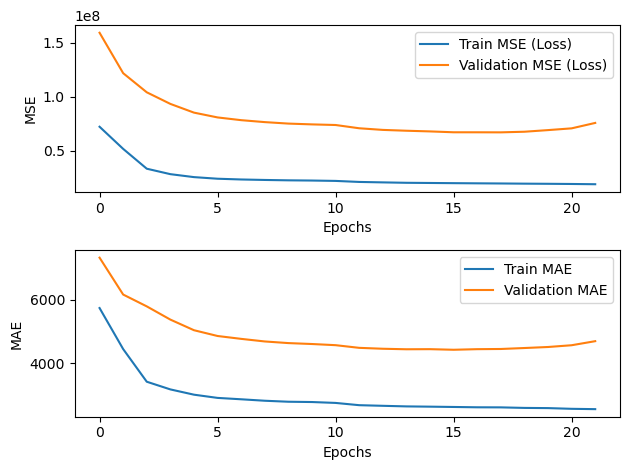

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 69132240.0000 - mean_absolute_error: 4832.8560


In [54]:
# LSTM model
lstm_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error",
    min_delta=10,
    patience=6,
    verbose=1,
    restore_best_weights=True
)


continuous_input = Input(
    shape=(
        train_inputs.shape[1], 
        train_inputs.shape[2], 
        continuous_train_inputs.shape[3]
    ), 
    name="continuous_input"
)

categorical_input = Input(
    shape=(
        train_inputs.shape[1], 
        train_inputs.shape[2], 
        categorical_train_inputs.shape[3]
    ), 
    name="categorical_input"
)

global_mean_tf = tf.constant(global_mean, dtype=tf.float32)
global_stddev_tf = tf.constant(global_stddev, dtype=tf.float32)
target_mean_tf = tf.constant(global_mean[0], dtype=tf.float32)
target_stddev_tf = tf.constant(global_stddev[0], dtype=tf.float32)

normalized_input = Lambda(lambda x: (x - global_mean_tf) / global_stddev_tf)(continuous_input)
noisy_input = GaussianNoise(stddev=0.1)(normalized_input)
combined_inputs = Concatenate(axis=-1)([noisy_input, categorical_input])
reshaped = Reshape(target_shape=(-1, combined_inputs.shape[3]))(combined_inputs)
lstm = LSTM(8, kernel_regularizer=tf.keras.regularizers.l2(0.004))(reshaped)
dense = Dense(54 * train_targets.shape[2])(lstm)
outputs = Reshape(target_shape=(54, train_targets.shape[2]))(dense)
denormalized_outputs = Lambda(lambda x: x * target_stddev_tf + target_mean_tf)(outputs)


lstm_model = Model(inputs=[continuous_input, categorical_input], outputs=denormalized_outputs)

lstm_model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.001))

print(lstm_model.summary())


history = lstm_model.fit(
    [continuous_train_inputs, categorical_train_inputs], 
    train_targets, 
    validation_data=([continuous_test_inputs, categorical_test_inputs], test_targets), 
    epochs=50, 
    batch_size=16, 
    callbacks=[lstm_es_callback]
)

fig, axs = plt.subplots(2)
axs[0].plot(history.history['loss'], label='Train MSE (Loss)')
axs[0].plot(history.history['val_loss'], label='Validation MSE (Loss)')
axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

eval = lstm_model.evaluate([continuous_val_inputs, categorical_val_inputs], val_targets)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ continuous_input    │ (None, 54, 14, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 54, 14, 3) │          0 │ continuous_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 54, 14, 3) │          0 │ lambda_2[0][0]    │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 54, 14, 4) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 54, 14, 7) │          0 │ gaussian_noise_1… │
│ (Concatenate)       │                   │            │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 756, 7)    │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 8)         │        408 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8)         │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 378)       │      3,402 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 54, 7)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 54, 7)     │          0 │ reshape_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,810 (14.88 KB)

 Trainable params: 3,810 (14.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 70669192.0000 - mean_absolute_error: 5642.6377 - val_loss: 132061400.0000 - val_mean_absolute_error: 6345.5640
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - loss: 37826800.0000 - mean_absolute_error: 3583.2061 - val_loss: 97002800.0000 - val_mean_absolute_error: 5252.6196
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - loss: 28327926.0000 - mean_absolute_error: 3193.0811 - val_loss: 81456096.0000 - val_mean_absolute_error: 4655.5874
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - loss: 26889656.0000 - mean_absolute_error: 3096.2427 - val_loss: 72023072.0000 - val_mean_absolute_error: 4354.2192
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - loss: 26046136.0000 - mean_absolute_error: 3047.5364 - val_loss: 67558504.0000 - val_mean_absolute_error: 4228.1626
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - loss: 24658452.0000 - mean_absolute_error: 3011.4329 - val_loss: 65065676.0000 - val

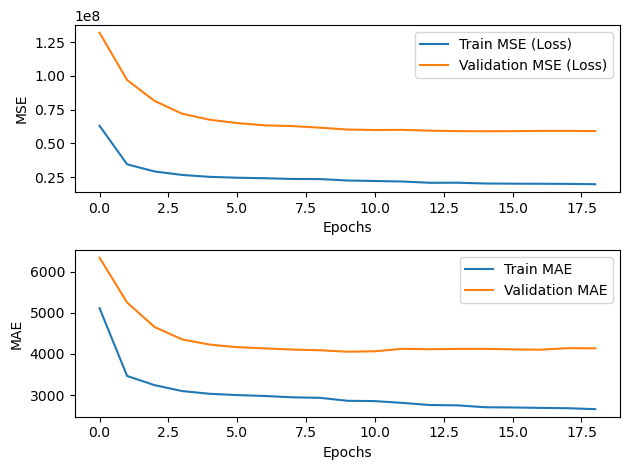

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 55501996.0000 - mean_absolute_error: 4433.3418


In [55]:
# GRU model
gru_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=10000,
    patience=4,
    verbose=1,
    restore_best_weights=True
)


continuous_input = Input(
    shape=(
        train_inputs.shape[1], 
        train_inputs.shape[2], 
        continuous_train_inputs.shape[3]
    ), 
    name="continuous_input"
)

categorical_input = Input(
    shape=(
        train_inputs.shape[1], 
        train_inputs.shape[2], 
        categorical_train_inputs.shape[3]
    ), 
    name="categorical_input"
)

global_mean_tf = tf.constant(global_mean, dtype=tf.float32)
global_stddev_tf = tf.constant(global_stddev, dtype=tf.float32)
target_mean_tf = tf.constant(global_mean[0], dtype=tf.float32)
target_stddev_tf = tf.constant(global_stddev[0], dtype=tf.float32)

normalized_input = Lambda(lambda x: (x - global_mean_tf) / global_stddev_tf)(continuous_input)
noisy_input = GaussianNoise(stddev=0.1)(normalized_input)
combined_inputs = Concatenate(axis=-1)([noisy_input, categorical_input])
reshaped = Reshape(target_shape=(-1, combined_inputs.shape[3]))(combined_inputs)
gru = GRU(8, kernel_regularizer=tf.keras.regularizers.l2(0.004))(reshaped)
dropout = Dropout(0.2)(gru)
dense = Dense(54 * train_targets.shape[2])(dropout)
outputs = Reshape(target_shape=(54, train_targets.shape[2]))(dense)
denormalized_outputs = Lambda(lambda x: x * target_stddev_tf + target_mean_tf)(outputs)

gru_model = Model(inputs=[continuous_input, categorical_input], outputs=denormalized_outputs)

gru_model.compile(loss='mean_squared_error', metrics=['mean_absolute_error'], optimizer=tf.keras.optimizers.Adam(0.002))

print(gru_model.summary())


history = gru_model.fit(
    [continuous_train_inputs, categorical_train_inputs], 
    train_targets, 
    validation_data=([continuous_test_inputs, categorical_test_inputs], test_targets), 
    epochs=50, 
    batch_size=16, 
    callbacks=[gru_es_callback]
)

fig, axs = plt.subplots(2)
axs[0].plot(history.history['loss'], label='Train MSE (Loss)')
axs[0].plot(history.history['val_loss'], label='Validation MSE (Loss)')
axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[0].legend()
axs[1].legend()
fig.tight_layout()
plt.show()

eval = gru_model.evaluate([continuous_val_inputs, categorical_val_inputs], val_targets)

In [99]:
estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='2.6',
    py_version='py38',
    hyperparameters={
        'batch_size': 16,
        'epochs': 50,
        'learning_rate': 0.002,
        'units': 8,
        'noise': 0.1,
        'l2_regularization': 0.004,
        'dropout': 0.2
    },
    output_path=f's3://{sagemaker_session.default_bucket()}/store-sales-forecasting/training-output/'
)

estimator.fit({
    'train': f"s3://{sagemaker_session.default_bucket()}/{train_prefix}", 
    'test':  f"s3://{sagemaker_session.default_bucket()}/{test_prefix}", 
    'validation':  f"s3://{sagemaker_session.default_bucket()}/{val_prefix}"
})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2024-10-07-23-20-33-707


2024-10-07 23:20:34 Starting - Starting the training job...
2024-10-07 23:20:49 Starting - Preparing the instances for training...
2024-10-07 23:21:13 Downloading - Downloading input data...
2024-10-07 23:21:38 Downloading - Downloading the training image...
2024-10-07 23:22:29 Training - Training image download completed. Training in progress..2024-10-07 23:22:36.168191: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-07 23:22:36.168360: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-10-07 23:22:36.195074: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-07 23:22:37,304 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2024-10-07 23:22:37,312 sagemaker-training-toolkit INFO     N

UnexpectedStatusException: Error for Training job tensorflow-training-2024-10-07-23-20-33-707: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
ExitCode 1
ErrorMessage "    raise TypeError('Not JSON Serializable:', obj)
 TypeError : ('Not JSON Serializable:', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([9754.295   ,   83.154274,   11.492299], dtype=float32)>)"
Command "/usr/local/bin/python3.8 train.py --batch_size 16 --dropout 0.2 --epochs 2 --l2_regularization 0.004 --learning_rate 0.002 --model_dir s3://sagemaker-us-east-1-757929513207/store-sales-forecasting/training-output/tensorflow-training-2024-10-07-23-20-33-707/model --noise 0.1 --units 8", exit code: 1